# Delay modeling
---

In this section, we will go deeper into analyzing the `istdaten` and `sbb_stops_lausanne_region` datasets to understand and develop a delay model. We will begin by cleaning the data and then proceed to analyze and extract relevant information. Our analysis will focus on various parameters, assessing their importance and relevance to the impact on delays. These parameters include the day of the week, specific hours of the day, the type of transport, and the station itself along with its traffic. This analysis will help us identify delay patterns at different stations.
Next, we will construct a dataframe that captures delays according to our selected parameters. This will enable us to predict delays for future trips.
Most importantly, it will allow us to calculate the probability of not missing a connection, ensuring timely arrival at our desired destination within our time constraints.

In [1]:
import os
import numpy as np
import plotly.express as px
import heapq
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, row_number, to_timestamp, unix_timestamp, from_unixtime, when, hour, date_format, avg, abs, first, count, to_date, dayofmonth, month, year, udf
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType 

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
4859,application_1713270977862_5377,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
print(f'Start Spark name:{spark._sc.appName}, version:{spark.version}')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Start Spark name:livy-session-4859, version:3.3.2.3.3.7190.2-1

In [3]:
type(spark)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.session.SparkSession'>

In [4]:
print(f"remote USER={os.getenv('USER',None)}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

remote USER=livy

In [5]:
print(f"local USER={os.getenv('USER',None)}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

local USER=livy

In [6]:
username=os.getenv('USER', 'anonymous')
hadoop_fs=os.getenv('HADOOP_DEFAULT_FS', 'hdfs://iccluster067.iccluster.epfl.ch:8020')
print(f"local username={username}\nhadoop_fs={hadoop_fs}")
 # (prevent deprecated np.bool error since numpy 1.24, until a new version of pandas/Spark fixes this)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

local username=livy
hadoop_fs=hdfs://iccluster067.iccluster.epfl.ch:8020

In [7]:
np.bool = np.bool_

username=spark.conf.get('spark.executorEnv.USERNAME', 'anonymous')
hadoop_fs=spark.conf.get('spark.executorEnv.HADOOP_DEFAULT_FS','hdfs://iccluster067.iccluster.epfl.ch:8020')
print(f"remote username={username}\nhadoop_fs={hadoop_fs}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

remote username=amrad
hadoop_fs=hdfs://iccluster067.iccluster.epfl.ch:8020

In [8]:
spark.sql(f'CREATE DATABASE IF NOT EXISTS {username}')
spark.sql(f'SHOW TABLES IN {username}').show(truncate=False)
spark.sql(f'SHOW TABLES IN {username}').toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------------------+-----------+
|namespace|tableName                       |isTemporary|
+---------+--------------------------------+-----------+
|amrad    |epd_expr_csv                    |false      |
|amrad    |epd_sam_csv                     |false      |
|amrad    |assignments                     |false      |
|amrad    |sbb_stops_lausanne_region       |false      |
|amrad    |sbb_stop_to_stop_lausanne_region|false      |
|amrad    |sbb_stop_times_lausanne_region  |false      |
|amrad    |weather_df                      |false      |
|amrad    |grouped_data                    |false      |
|amrad    |delay_clean_df                  |false      |
+---------+--------------------------------+-----------+

  namespace                         tableName  isTemporary
0     amrad                      epd_expr_csv        False
1     amrad                       epd_sam_csv        False
2     amrad                       assignments        False
3     amrad         sb

### Import data and merge

In [10]:
df = spark.read.orc('/data/sbb/orc/istdaten')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df = df.withColumnRenamed('BETRIEBSTAG', 'operation_date') \
    .withColumnRenamed('FAHRT_BEZEICHNER', 'journey_identifier') \
    .withColumnRenamed('BETREIBER_ID', 'operator_id') \
    .withColumnRenamed('BETREIBER_ABK', 'operator_abbreviation') \
    .withColumnRenamed('BETREIBER_NAME', 'operator_name') \
    .withColumnRenamed('PRODUKT_ID', 'product_id') \
    .withColumnRenamed('LINIEN_ID', 'line_id') \
    .withColumnRenamed('LINIEN_TEXT', 'line_text') \
    .withColumnRenamed('UMLAUF_ID', 'circuit_id') \
    .withColumnRenamed('VERKEHRSMITTEL_TEXT', 'transportation_mode_text') \
    .withColumnRenamed('ZUSATZFAHRT_TF', 'additional_trip') \
    .withColumnRenamed('FAELLT_AUS_TF', 'trip_cancellation') \
    .withColumnRenamed('BPUIC', 'stop_id') \
    .withColumnRenamed('HALTESTELLEN_NAME', 'stop_name') \
    .withColumnRenamed('ANKUNFTSZEIT', 'arrival_time') \
    .withColumnRenamed('AN_PROGNOSE', 'arrival_forecast') \
    .withColumnRenamed('AN_PROGNOSE_STATUS', 'arrival_forecast_status') \
    .withColumnRenamed('ABFAHRTSZEIT', 'departure_time') \
    .withColumnRenamed('AB_PROGNOSE', 'departure_forecast') \
    .withColumnRenamed('AB_PROGNOSE_STATUS', 'departure_forecast_status') \
    .withColumnRenamed('DURCHFAHRT_TF', 'non_stop') \
    .withColumnRenamed('YEAR', 'year') \
    .withColumnRenamed('MONTH', 'month')
df.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------------+-----------+---------------------+-------------+----------+-------+---------+----------+------------------------+---------------+-----------------+-------+--------------------+----------------+-------------------+-----------------------+----------------+-------------------+-------------------------+--------+----+-----+
|operation_date|journey_identifier|operator_id|operator_abbreviation|operator_name|product_id|line_id|line_text|circuit_id|transportation_mode_text|additional_trip|trip_cancellation|stop_id|           stop_name|    arrival_time|   arrival_forecast|arrival_forecast_status|  departure_time| departure_forecast|departure_forecast_status|non_stop|year|month|
+--------------+------------------+-----------+---------------------+-------------+----------+-------+---------+----------+------------------------+---------------+-----------------+-------+--------------------+----------------+-------------------+-----------------------+----------------

We will be focusing exclusively on data from 2023

In [12]:
df = df.filter((col("year") == 2023))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
lausanne_stops_df = spark.sql(f"SELECT * FROM {username}.sbb_stops_lausanne_region ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
lausanne_stops_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+---------------+--------------+
|    stop_id|           stop_name|       stop_lat|      stop_lon|
+-----------+--------------------+---------------+--------------+
|    8593869|Chavannes-R., Gly...|46.536280459692|6.576575179107|
|    8592215|Renens VD, Longem...|46.525576568081|6.596598626793|
|    8592204|Renens VD, Bois-G...|46.546302630167| 6.58426475794|
|    8592188|   Pully, Montillier|46.512366838577|6.657657116663|
|    8592170| Pully, Bourdonnière|46.506530539992|6.646589872361|
|    8592137|  Lausanne, Cascades|46.540154847283|6.641208963809|
|    8592130|Lausanne, Vert-Bo...|46.560498567613|6.684965901304|
|    8592105|Lausanne, Provenc...|46.524136449395|6.606138735112|
|    8592038| Lausanne, Eglantine|46.516329476459|6.641882700272|
|    8592011|Lausanne, Chauder...|46.523802682534|6.627294060056|
|    8592006|Lausanne, Chalet-...| 46.56775571707|6.699707255119|
|    8588873| Ecublens VD, Pontet|46.529785451483|6.566019974517|
|    85884

In [15]:
lausanne_stops_df = lausanne_stops_df.withColumnRenamed("stop_name", "stop_name_2")
lausanne_stops_df = lausanne_stops_df.withColumnRenamed("stop_id", "stop_id_2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
merged_ist_df = df.alias("df").join(
    lausanne_stops_df.alias("lausanne"),
    col("df.stop_name") == col("lausanne.stop_name_2"),
    "inner"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
merged_ist_df = merged_ist_df.drop("stop_name_2")
merged_ist_df = merged_ist_df.drop("stop_id_2")
merged_ist_df.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+-----------+---------------------+---------------+----------+-------------+---------+----------+------------------------+---------------+-----------------+-------+--------------------+----------------+-------------------+-----------------------+----------------+-------------------+-------------------------+--------+----+-----+---------------+--------------+
|operation_date|  journey_identifier|operator_id|operator_abbreviation|  operator_name|product_id|      line_id|line_text|circuit_id|transportation_mode_text|additional_trip|trip_cancellation|stop_id|           stop_name|    arrival_time|   arrival_forecast|arrival_forecast_status|  departure_time| departure_forecast|departure_forecast_status|non_stop|year|month|       stop_lat|      stop_lon|
+--------------+--------------------+-----------+---------------------+---------------+----------+-------------+---------+----------+------------------------+---------------+-----------------+-------+------

## Cleaning part

In [18]:
merged_ist_df_clean = merged_ist_df.filter((merged_ist_df['additional_trip'] == False) # We remove additional trips
                                       & (merged_ist_df['non_stop'] == False) # We remove trips where the transport do not stop
                                       & (merged_ist_df['trip_cancellation'] == False)).select( # We remove failed trips 
        merged_ist_df['operation_date'], 
        merged_ist_df['product_id'], # transport type
        merged_ist_df['stop_name'],
        merged_ist_df['stop_id'],
        F.to_timestamp(merged_ist_df["arrival_time"], 'dd.MM.yyy HH:mm').alias("arrival_time"),
        F.to_timestamp(merged_ist_df["arrival_forecast"], 'dd.MM.yyyy HH:mm:ss').alias("actual_arrival_time"),
        merged_ist_df['arrival_forecast_status'],
        F.to_timestamp(merged_ist_df["departure_time"], 'dd.MM.yyy HH:mm').alias("departure_time"),
        F.to_timestamp(merged_ist_df["departure_forecast"], 'dd.MM.yyyy HH:mm:ss').alias("actual_departure_time"),
        merged_ist_df["departure_forecast_status"],
        merged_ist_df["year"],
        merged_ist_df["month"],
        merged_ist_df["stop_lat"],
        merged_ist_df["stop_lon"])



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
merged_ist_df_clean.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+
|operation_date|product_id|           stop_name|stop_id|       arrival_time|actual_arrival_time|arrival_forecast_status|     departure_time|actual_departure_time|departure_forecast_status|year|month|       stop_lat|      stop_lon|
+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+
|    22.12.2023|       Bus|Lausanne, Bourdon...|8501210|               null|               null|                       |2023-12-22 05:40:00|  2023-12-22 05:40:12|                 PROGNOSE|2023|   12|46.523264942721|6.589807363244|
|    22.12.2023|       Bus|Ecublens VD, allé...|8591950|2023-12-22 05:41:00|

In [20]:
nb = merged_ist_df_clean.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We keep only **real** value for the arrival time.


In [21]:
merged_ist_df_clean = merged_ist_df_clean.filter(merged_ist_df_clean['departure_forecast_status'] == "REAL")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
merged_ist_df_clean.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4224498

We remove also rows where departure time < arrival time. This situation is not possible

In [23]:
merged_df_clean = merged_ist_df_clean.filter(( merged_ist_df_clean.actual_arrival_time <= merged_ist_df_clean.actual_departure_time))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We remove empty product_id (no transport type defined) and null values.

In [24]:
# we remove null values
merged_df_clean = merged_df_clean.filter(col("product_id") != '')
merged_df_clean = merged_df_clean.dropna(subset=[ 'arrival_time', 'departure_time', 'actual_arrival_time', 'actual_departure_time'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
print(merged_df_clean.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3845415

In [26]:
#Add some columns
merged_df_clean = merged_df_clean.withColumn("departure_delay", abs(unix_timestamp("actual_departure_time") - unix_timestamp("departure_time")))
merged_df_clean = merged_df_clean.withColumn("arrival_delay", abs(unix_timestamp("actual_arrival_time") - unix_timestamp("arrival_time")))
merged_df_clean = merged_df_clean.withColumn("departure_time_hour", hour("departure_time"))
merged_df_clean = merged_df_clean.withColumn("arrival_time_hour", hour("arrival_time"))
merged_df_clean = merged_df_clean.withColumn("day_name", date_format("departure_time", "EEEE"))
# day of the week (1: Dimanche),(2 : Lundi),(3 : Mardi),(4 : Mercredi),(5 : Jeudi),(6 : Vendredi),(7 : Samedi)
merged_df_clean = merged_df_clean.withColumn('day_of_week', F.dayofweek(merged_df_clean.departure_time))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
merged_df_clean.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+---------------+-------------+-------------------+-----------------+--------+-----------+
|operation_date|product_id|           stop_name|stop_id|       arrival_time|actual_arrival_time|arrival_forecast_status|     departure_time|actual_departure_time|departure_forecast_status|year|month|       stop_lat|      stop_lon|departure_delay|arrival_delay|departure_time_hour|arrival_time_hour|day_name|day_of_week|
+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+---------------+-------------+-------------------+-----------------+--------+-----------+
|    22.12.2023|       Bus|Ecublens VD, 

We filter out the irrelevant hour. As it was said we will focus only on regular and relevant hour of the day

In [28]:
merged_df_clean = merged_df_clean.where(((merged_df_clean.arrival_time_hour) >= 6)
                                          & ((merged_df_clean.arrival_time_hour) <= 22)
                                          & (merged_df_clean.day_of_week >= 2) 
                                          & (merged_df_clean.day_of_week <= 6))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Delay per hour of a day analysis

In [29]:
mean_delay_by_hour = merged_df_clean.groupby('arrival_time_hour').agg(F.mean('arrival_delay').alias('mean_delay')).orderBy('arrival_time_hour')
mean_delay_by_hour_df = mean_delay_by_hour.toPandas().sort_values('arrival_time_hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

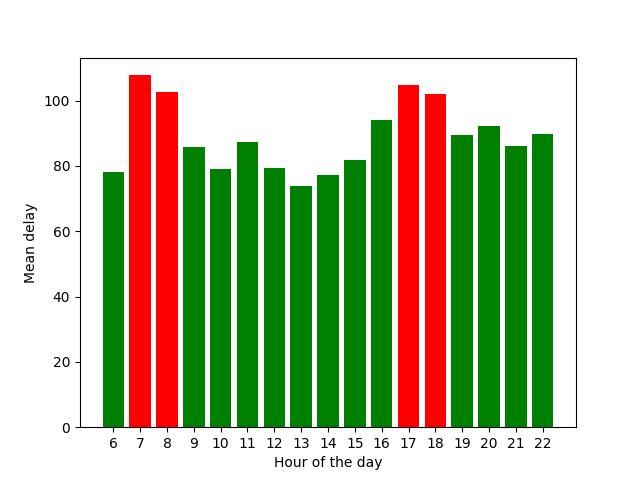

In [30]:
color = ['r' if x in [7, 8, 17, 18]
               else 'g' for x in range(6, 22)]

plt.figure()
plt.bar(mean_delay_by_hour_df['arrival_time_hour'], mean_delay_by_hour_df['mean_delay'], color =color)
plt.xlabel('Hour of the day')
plt.ylabel('Mean delay')
plt.xticks(range(6, 23))
plt.show()
%matplot plt

In [31]:
@F.udf
def get_hour_cat(hour):
    hour_categorie = 0
    if hour in [7, 8, 17,18]:
        hour_categorie = 1 # rush hour
    else:
        hour_categorie = 2   
    return hour_categorie

merged_df_clean = merged_df_clean.withColumn('hour_cat', get_hour_cat(merged_df_clean.arrival_time_hour).cast(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Clearly we have significantly more delay during the rush hours, which correspond to the moment where people usually goes to work and back to their home. We thus decide to create a categorie of hour to emphasise on that.

In [32]:
merged_df_clean.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+---------------+-------------+-------------------+-----------------+--------+-----------+--------+
|operation_date|product_id|           stop_name|stop_id|       arrival_time|actual_arrival_time|arrival_forecast_status|     departure_time|actual_departure_time|departure_forecast_status|year|month|       stop_lat|      stop_lon|departure_delay|arrival_delay|departure_time_hour|arrival_time_hour|day_name|day_of_week|hour_cat|
+--------------+----------+--------------------+-------+-------------------+-------------------+-----------------------+-------------------+---------------------+-------------------------+----+-----+---------------+--------------+---------------+-------------+-------------------+-----------------+--------+-----------+--------+
|    22.12.20

### delay per day of the week analysis

In [33]:
delay_by_day_of_week = merged_df_clean.groupby('day_of_week').agg(F.mean('arrival_delay').alias('mean_delay'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
delay_by_day_of_week_df = delay_by_day_of_week.toPandas().sort_values('day_of_week')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
delay_by_day_of_week_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   day_of_week  mean_delay
4            2   89.660139
1            3   90.138558
3            4   86.870056
2            5   89.181492
0            6   91.575775

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

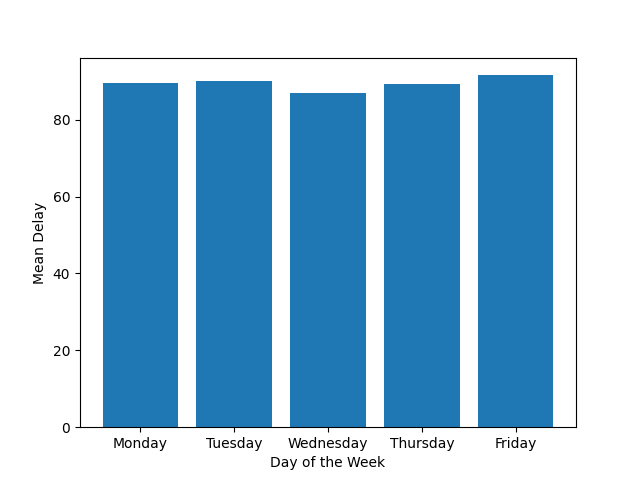

In [36]:
delay_by_day_of_week_df = delay_by_day_of_week_df[(delay_by_day_of_week_df['day_of_week'] >= 2) & (delay_by_day_of_week_df['day_of_week'] <= 6)]

plt.figure()

plt.bar(delay_by_day_of_week_df['day_of_week'] - 2, delay_by_day_of_week_df['mean_delay'])
plt.xlabel('Day of the Week')
plt.ylabel('Mean Delay')
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
plt.xticks(range(len(weekdays)), weekdays)

plt.show()
%matplot plt

There is no significant difference. We will thus not take into account the day in the creating of the average delay dataframe

#### Creation of the final cleaned dataframe

In [37]:
merged_df_clean_new = merged_df_clean.select(merged_df_clean["stop_name"],
                                         merged_df_clean["product_id"],
                                         merged_df_clean["hour_cat"],
                                         merged_df_clean["day_name"],
                                         merged_df_clean["arrival_delay"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
merged_df_clean_new.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------+--------+-------------+
|           stop_name|product_id|hour_cat|day_name|arrival_delay|
+--------------------+----------+--------+--------+-------------+
|Ecublens VD, allé...|       Bus|       2|  Friday|          223|
|Ecublens VD, Blév...|       Bus|       2|  Friday|          250|
|Ecublens VD, Cham...|       Bus|       2|  Friday|          241|
|St-Sulpice VD, Pâ...|       Bus|       2|  Friday|          189|
|St-Sulpice VD, Pa...|       Bus|       2|  Friday|          199|
+--------------------+----------+--------+--------+-------------+
only showing top 5 rows

**We will use this dataframe now through the rest of our notebook**

### Showing again the significant difference between rush and normal hour

In [39]:
mean_delay_by_cat = merged_df_clean_new.groupby('hour_cat').agg(F.mean('arrival_delay').alias('mean_delay'))
mean_delay_by_cat_df = mean_delay_by_cat.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
mean_delay_by_cat_df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   hour_cat  mean_delay
0         1  104.341580
1         2   84.017537

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

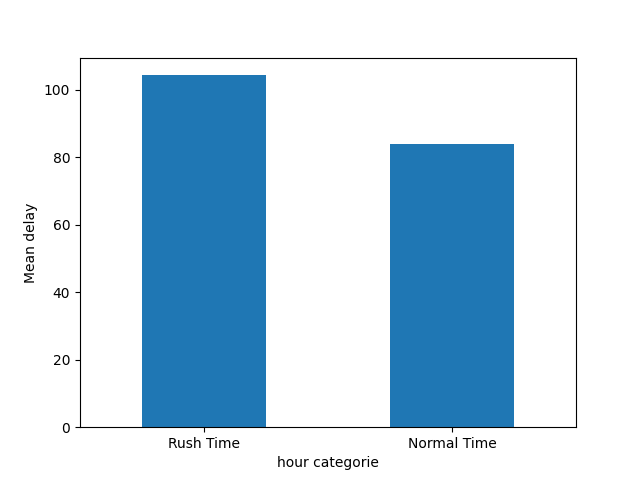

In [41]:
plt.figure()
plot= mean_delay_by_cat_df.plot(kind='bar', x='hour_cat', y='mean_delay', legend=None)
plt.xlabel('hour categorie')
plt.ylabel('Mean delay')
labels = ['Rush Time', 'Normal Time']
plt.xticks(ticks=plot.get_xticks(), labels=labels, rotation=0) 
plt.show()
%matplot plt

### Delay per transport type analysis

In [42]:
mean_delay_product = merged_df_clean_new.groupby('product_id').agg(F.mean('arrival_delay').alias('mean_delay'))
mean_delay_product_df = mean_delay_product.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

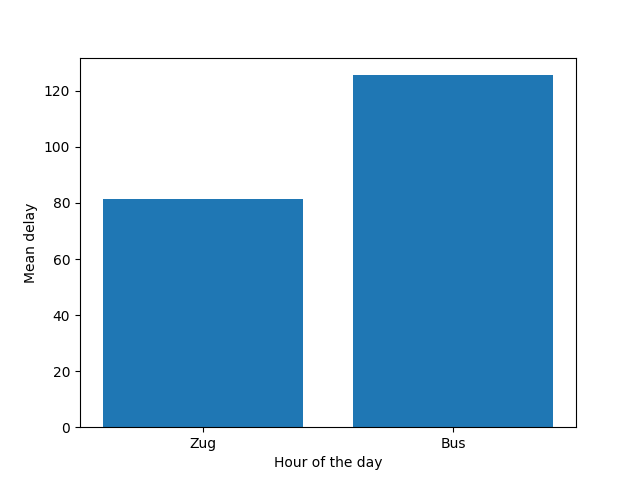

In [43]:
plt.figure()
plt.bar(mean_delay_product_df['product_id'], mean_delay_product_df['mean_delay'])
plt.xlabel('Hour of the day')
plt.ylabel('Mean delay')
plt.show()
%matplot plt

Clearly bus have significantly more delay that the train/metro. This information is relevant and will be used to create our dataframe

### Delay distribution analysis

In [44]:
sampled_df = merged_df_clean_new.sample(withReplacement=False, fraction=0.05, seed=42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
delays_pd = sampled_df.select('arrival_delay').toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

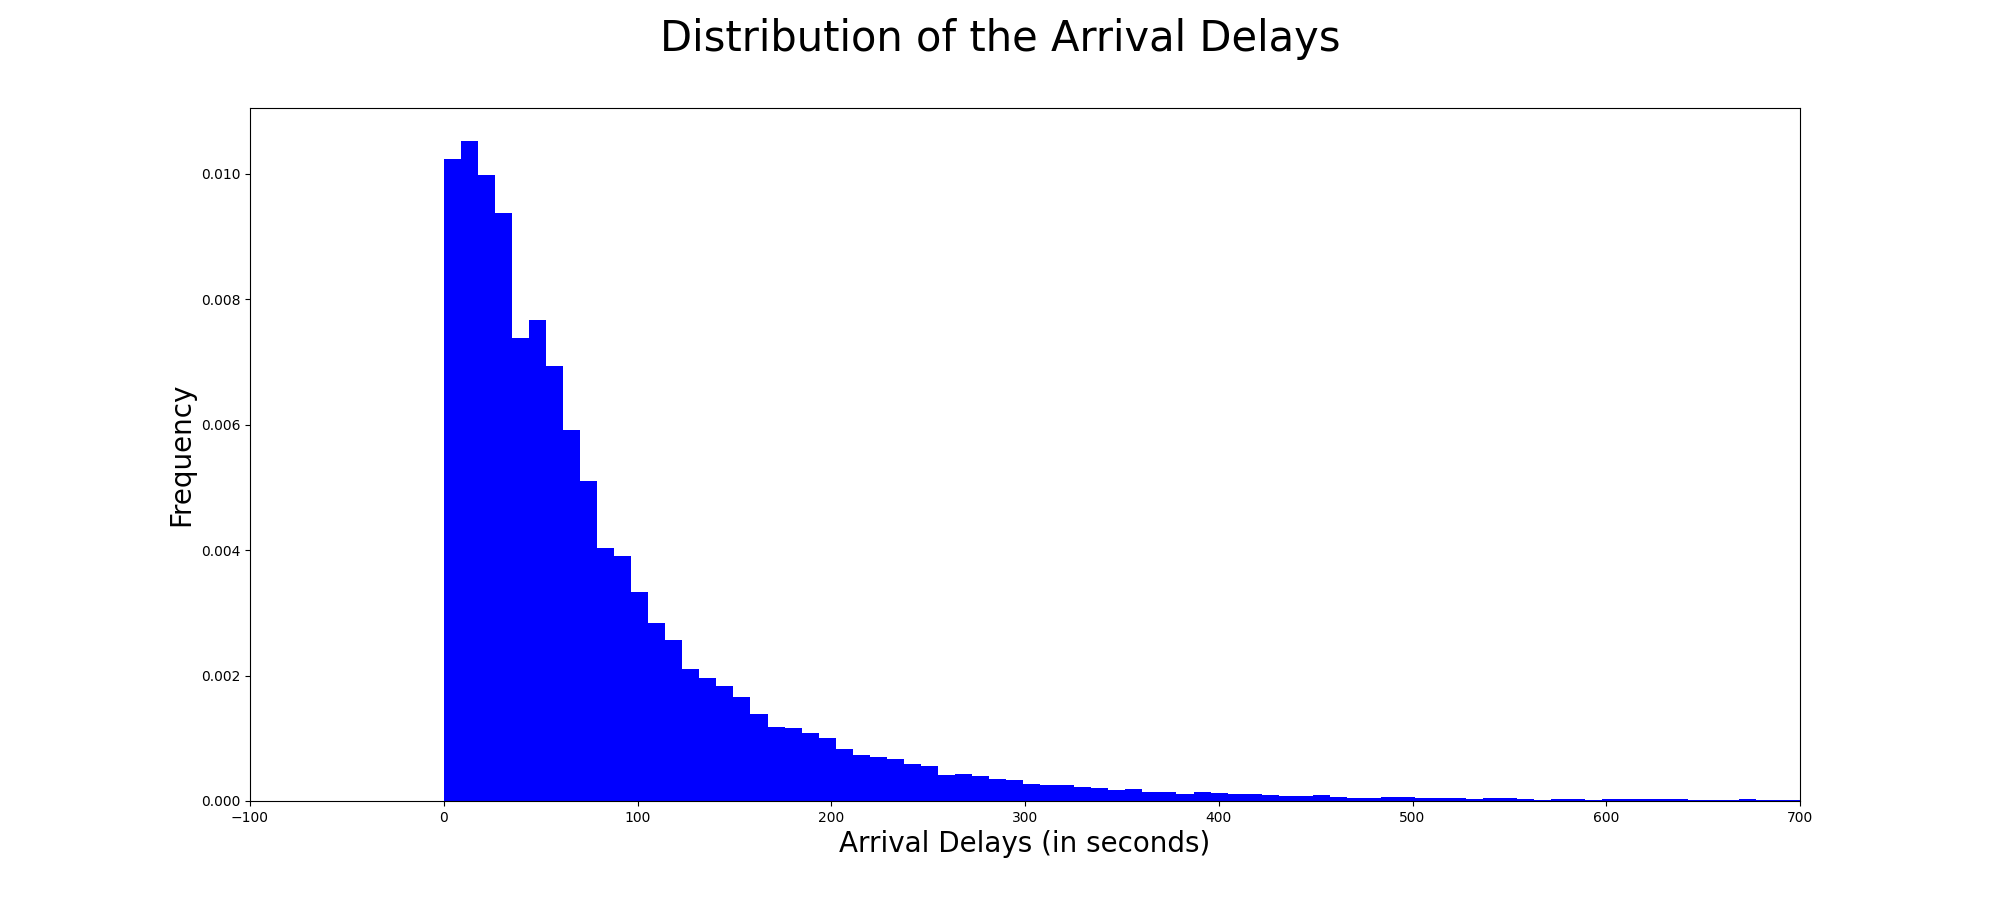

In [46]:
%%spark

# Assuming delays_pd is your DataFrame and it contains the 'arrival_delay' column
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 9))

# Plotting the histogram for arrival delay
ax.hist(delays_pd.arrival_delay, color='b', bins=1000, density=True)

# Setting the title and labels
fig.suptitle('Distribution of the Arrival Delays', fontsize=30)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlim(-100, 700)
ax.set_xlabel('Arrival Delays (in seconds)', fontsize=20)


# Display the plot
plt.show()
%matplot plt

The graph above shows the distribution of arrival delays across various stations. The data was sampled and processed to focus on arrival delays, which are measured in seconds.

The distribution of arrival delays appears to follow an exponential pattern. This is characterized by a high frequency of small delays and a rapid decline as the delay duration increases. The exponential distribution is often used to model the time between events in a Poison process. The distribution is heavily skewed to the right, with a long tail extending towards higher delay values. This indicates that while most delays are short, there are occasional longer delays that occur less frequently.

In [47]:
sampled_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------+--------+-------------+
|           stop_name|product_id|hour_cat|day_name|arrival_delay|
+--------------------+----------+--------+--------+-------------+
|Ecublens VD, Villars|       Bus|       2|  Friday|          154|
|            Lausanne|       Zug|       1| Tuesday|           58|
|            Lausanne|       Zug|       2| Tuesday|           18|
|            Lausanne|       Zug|       2| Tuesday|            6|
|            Lausanne|       Zug|       2| Tuesday|           67|
+--------------------+----------+--------+--------+-------------+
only showing top 5 rows

### Show the grouped dataframe we will use to get the delay

In [48]:
df_grouped = sampled_df.groupBy("stop_name", "hour_cat","product_id").agg( avg(col("arrival_delay")).alias("avg_arrival_delay"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
df_grouped.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+----------+------------------+
|           stop_name|hour_cat|product_id| avg_arrival_delay|
+--------------------+--------+----------+------------------+
|            Bussigny|       1|       Zug|121.86344151867728|
|Servion, poste/cr...|       2|       Bus|102.29711751662971|
|Montblesson, Cent...|       2|       Bus|106.53459119496856|
|          Pully-Nord|       2|       Zug| 95.59579100145137|
|       La Conversion|       1|       Zug|100.92063492063492|
+--------------------+--------+----------+------------------+
only showing top 5 rows

In [50]:
print(df_grouped.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

127

## Probability calculation

In [58]:
def to_sec(hour):
    '''
    Transform a time given in a string format to seconds
    input:
        - string(hour): The string datetime in the format 'hh:mm:ss'
    output:
        - float(second): The number of seconds corresponding to the hour string
    '''
    split = hour.split(':')
    return float(split[0])*60*60 + float(split[1])*60 + float(split[2])


def exponential_distribution_proba(available_time, avg_delay):
    if available_time <= 0 :
        return 0
    if avg_delay == 0:
        return 1
    proba =  1 - np.exp(-available_time/avg_delay)
    
    return proba 

def seconds_to_rounded_hour(seconds):
    '''
    Converts seconds to the nearest rounded down hour.

    Args:
    seconds (int): The number of seconds.

    Returns:
    int: The hour number rounded down.
    '''
    hours = seconds // 3600  
    return hours
    
def get_hour_cat(num):
    """
    Categorize the given number into two categories based on its value.
    
    Args:
        num (int): The number to categorize.

    Returns:
        int: 1 if the number is 7, 8, 17, or 18 (rush time9 , otherwise 2 (normal time).
    """
    if num in [7, 8, 17, 18]:
        return 1
    else:
        return 2
        
def get_mean_delay_for_cat(hour_cat,df):
    
    delay = df.loc[df['hour_cat'] == hour_cat, 'mean_delay']
    
    if not delay.empty:
        return delay.values[0] 
    else:
        return None  

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cumulative distribution function for exponential distribution
$$
F(x; \lambda) = \begin{cases} 
1 - e^{-\lambda x} & \text{if } x \geq 0, \\
0 & \text{if } x < 0.
\end{cases}
$$

where **Mean** is : 

$$
\frac{1}{\lambda}
$$


In [59]:
# save the df to hdfs 
username=spark.conf.get('spark.executorEnv.USERNAME', 'anonymous')
hadoop_fs=spark.conf.get('spark.executorEnv.HADOOP_DEFAULT_FS','hdfs://iccluster067.iccluster.epfl.ch:8020')
print(f"remote username={username}\nhadoop_fs={hadoop_fs}")

spark.sql(f"CREATE DATABASE IF NOT EXISTS {username}")
spark.sql(f"USE {username}")
table_name = "delay_clean_df"
merged_df_clean_new.write.mode("overwrite").saveAsTable(f"{username}.{table_name}")
spark.sql(f"SHOW TABLES IN {username}").show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

remote username=amrad
hadoop_fs=hdfs://iccluster067.iccluster.epfl.ch:8020
+---------+--------------------------------+-----------+
|namespace|tableName                       |isTemporary|
+---------+--------------------------------+-----------+
|amrad    |epd_expr_csv                    |false      |
|amrad    |epd_sam_csv                     |false      |
|amrad    |assignments                     |false      |
|amrad    |sbb_stops_lausanne_region       |false      |
|amrad    |sbb_stop_to_stop_lausanne_region|false      |
|amrad    |sbb_stop_times_lausanne_region  |false      |
|amrad    |weather_df                      |false      |
|amrad    |grouped_data                    |false      |
|amrad    |delay_clean_df                  |false      |
+---------+--------------------------------+-----------+

## Validation 

In [69]:
avg_delay = merged_df_clean_new.select('stop_name', 'product_id', 'hour_cat', 'arrival_delay').groupBy('stop_name', 'product_id', 'hour_cat').agg(F.avg('arrival_delay').alias("average_delay"))

mse_df = merged_df_clean_new.join(avg_delay, on=['stop_name', 'product_id', 'hour_cat'])

mse_df = mse_df.withColumn("squared_error", (mse_df.arrival_delay - mse_df.average_delay) ** 2)

mse = mse_df.agg(F.avg("squared_error").alias("mse")).collect()[0]['mse']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mean Square Error of the delay: 18511.598760301327

In [73]:
# Printing the MSE
print("Mean Square Error of the delay:", mse)
rmse = np.sqrt(mse)
print("Root Mean Square Error of the delay:", rmse, "seconds")
print("Root Mean Square Error of the delay:", rmse/60, "minutes")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mean Square Error of the delay: 18511.598760301327
Root Mean Square Error of the delay: 136.05733629724392 seconds
Root Mean Square Error of the delay: 2.267622271620732 minutes

After computing the root mean squared error of the arrival delays compared to the mean delay in each stop for a given transport type and time category, we find that the rsme is of 2.26 minutes. This result is convincing in the fact that the way we compute the estimated delay is correct. The estimated delays don't deviate much from the mean we computed

# END

In [63]:
#spark.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…